In [347]:
import import_ipynb
import seaborn as sns
import numpy as np
import pandas as pd
import pyvinecopulib as pv
import scipy
import seaborn as sns
from scipy.stats import nct, laplace_asymmetric ,genhyperbolic, laplace , t
import pandas_ta as ta

from scipy import stats

In [348]:
from app.historical_price import HistoricalPrice
from app.random_variable import RandomVariable
from app.scrapers.vndirect import Ticker

In [349]:
pair = ['PLP','DRH','PDR','MBS','TCD','GSP','GSP','NSH','TTH','QBS']

In [350]:
asset = 'VTB'
hp = HistoricalPrice()

df = hp.read(asset)
df = df.loc[:,[i for i in df.columns if 'order' not in i]]
order = hp.get_order_info(asset)

order = order.replace(0, np.nan).interpolate()
order = order.replace(np.inf, np.nan).interpolate()
df = df.join(order).dropna()
df.index =  pd.to_datetime(df.index)
# df.index = pd.DatetimeIndex(df.index).to_period('D')
df['net_volume'] = df['ChenhLechKL']

df = df.filter(items=['close','net_volume'])
print(df.shape)
df.head()

(4100, 2)


,close,net_volume
date,,
2007-07-02,67.0,-9590.0
2007-07-03,65.0,-10150.0
2007-07-04,67.0,-7290.0
2007-07-05,66.0,-16270.0
2007-07-06,63.5,-11120.0


In [351]:
temp = df.copy()
temp = temp.resample('M').agg({'close':'last', 'net_volume':'sum'})

temp['returns']=temp['close']/temp['close'].shift(1) - 1
temp = temp.dropna()
temp.tail()

,close,net_volume,returns
date,,,
2023-08-31,10.95,-409400.0,-0.047826
2023-09-30,10.75,-547300.0,-0.018265
2023-10-31,9.05,-505900.0,-0.158140
2023-11-30,9.84,-350200.0,0.087293
2023-12-31,11.45,-486600.0,0.163618


In [352]:
tau, p_value = stats.kendalltau(temp['net_volume'],temp['returns'])
tau,p_value

(0.1621621818163339, 0.0007190034196302908)

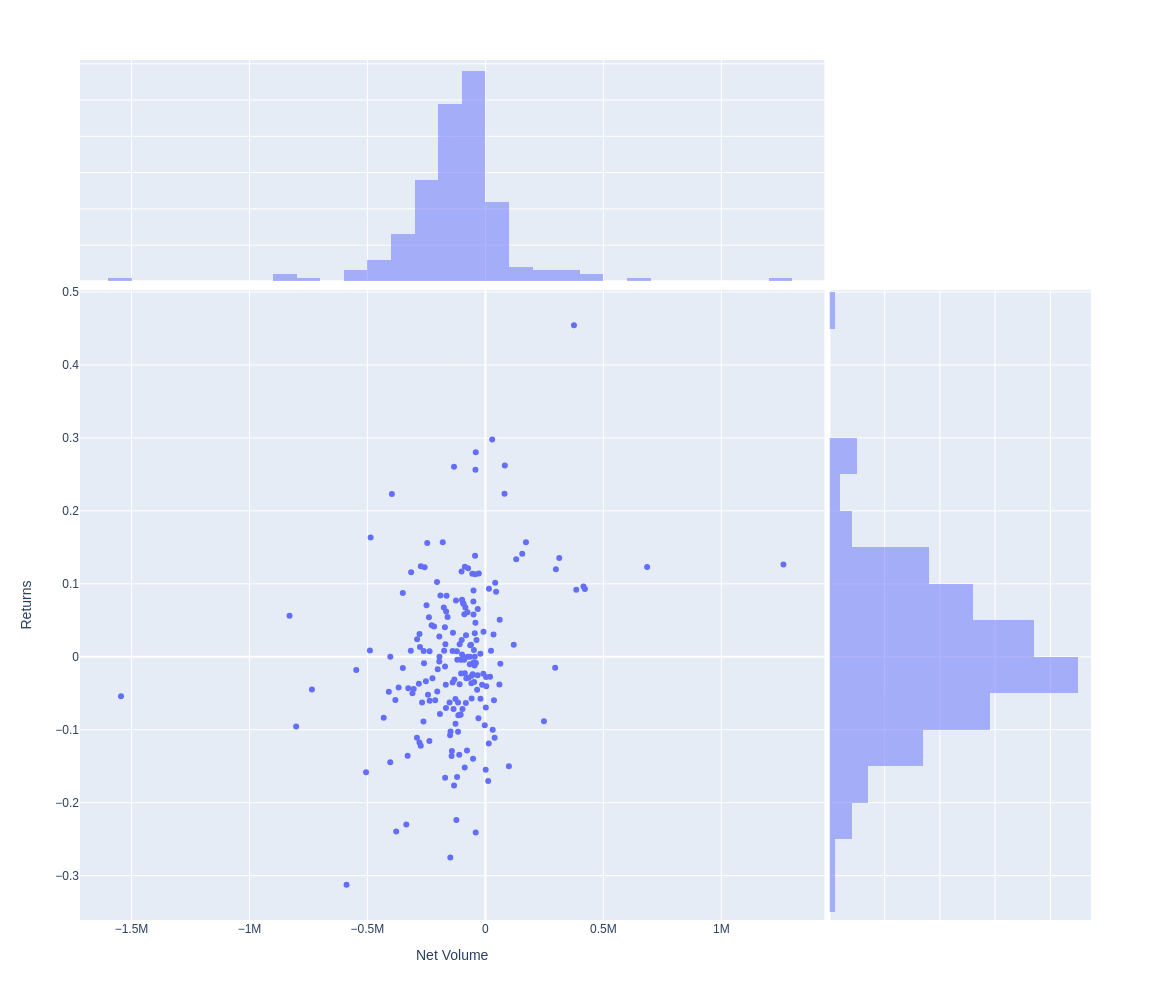

In [353]:
import plotly.graph_objects as go
import plotly.express as px 

fig = px.scatter(temp, x="net_volume", y="returns", marginal_x="histogram", marginal_y="histogram")
fig.update_layout(
    xaxis_title="Net Volume",
    yaxis_title="Returns",
    height=1000,
    width=1250,
)
fig.show()

In [357]:
import requests
from datetime import datetime, timezone
import json
import pytz

local_timezone =pytz.timezone('Asia/Ho_Chi_Minh')

HEADERS = {
    "Accept": "*/*",
    "Accept-Language": "en-US,en;q=0.9",
    "Connection": "keep-alive",
    "Origin": "https://dstock.vndirect.com.vn",
    "Referer": "https://dstock.vndirect.com.vn/",
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "same-site",
    "User-Agent": "Mozilla/5.0 (X11; Windows x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36",
    "sec-ch-ua": '"Chromium";v="110", "Not A(Brand";v="24", "Google Chrome";v="110"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"Windows"',
}


today = datetime.today().date()
utc_time = datetime(
    today.year, today.month, today.day-20, 10, 0, 0, tzinfo=timezone.utc
)

timestamp = int(utc_time.timestamp())
params = {
    "resolution": "1",
    "symbol": ticker,
    "from": timestamp,
    "countback": 2
}
response = requests.get(
    "https://dchart-api.vndirect.com.vn/dchart/history",
    params=params,headers=HEADERS
)
data = json.loads(response.content)
df = pd.DataFrame.from_dict(data)
print(df.shape,df.head())

(128, 7)             t      c      o      h      l     v   s
0  1702003080  11.25  11.30  11.30  11.25  2700  ok
1  1702003380  11.15  11.20  11.20  11.15  1400  ok
2  1702003980  11.20  11.20  11.20  11.20   100  ok
3  1702004100  11.15  11.15  11.15  11.15   100  ok
4  1702004340  11.20  11.20  11.20  11.20  1000  ok


In [358]:
df['t'] = df['t'].apply(lambda x: datetime.utcfromtimestamp(x).astimezone(local_timezone))
df['r'] = df['c'] /df['c'].shift() - 1
df= df.dropna()
print(stats.kendalltau(df['v'],df['r']))
df

SignificanceResult(statistic=-0.02284283947354099, pvalue=0.7466625919087866)


,t,c,o,h,l,v,s,r
1,2023-12-08 02:43:00+07:00,11.15,11.20,11.20,11.15,1400,ok,-0.008889
2,2023-12-08 02:53:00+07:00,11.20,11.20,11.20,11.20,100,ok,0.004484
3,2023-12-08 02:55:00+07:00,11.15,11.15,11.15,11.15,100,ok,-0.004464
4,2023-12-08 02:59:00+07:00,11.20,11.20,11.20,11.20,1000,ok,0.004484
5,2023-12-08 04:00:00+07:00,11.20,11.20,11.20,11.20,200,ok,0.000000
6,2023-12-08 06:53:00+07:00,11.30,11.30,11.30,11.30,100,ok,0.008929
7,2023-12-08 06:58:00+07:00,11.30,11.30,11.30,11.30,200,ok,0.000000
8,2023-12-11 02:15:00+07:00,11.35,11.35,11.35,11.35,300,ok,0.004425
9,2023-12-11 02:36:00+07:00,11.35,11.35,11.35,11.35,500,ok,0.000000
10,2023-12-11 02:43:00+07:00,11.40,11.40,11.40,11.40,100,ok,0.004405


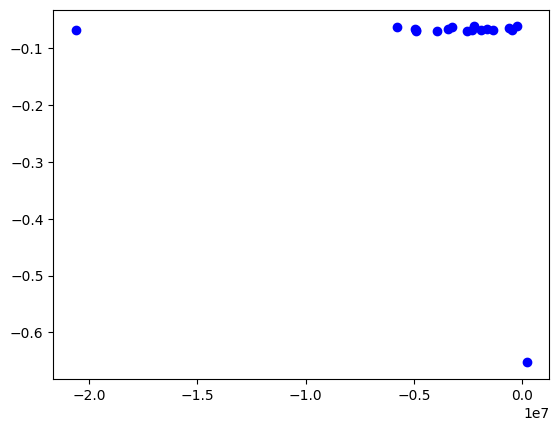

In [278]:
sub = temp[temp['returns']<-0.06]
plt.scatter(sub['net_volume'], sub['returns'],color='b')

In [279]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_squared_error

def func(x, a, b):
    return a*x+b

In [280]:
large_volume = np.quantile(temp['net_volume'],0.95)
large_volume

3989434.9999999967

In [127]:
temp = temp.loc[(temp['net_volume']<5000000)&(temp['net_volume']>-5000000)].sort_values(by=['net_volume'],ascending=True)
temp.shape

(2597, 3)

[2.19254090e-08 4.02256341e-03]


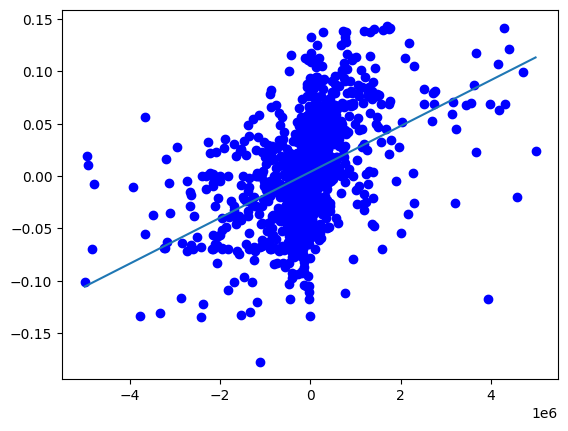

In [106]:
popt, pcov = curve_fit(func, temp['net_volume'], temp['returns'])

print(popt)
pred = func(temp['net_volume'], *popt)
# print(popt,np.linalg.cond(pcov),mean_squared_error(X[:,1],pred),mean_absolute_error(X[:,1],pred))
plt.scatter( temp['net_volume'], temp['returns'],color='b')
# plt.scatter(sim_returns[pair[0]], sim_returns[pair[1]],color='r')
plt.plot( temp['net_volume'], pred)

In [103]:
tickers = Ticker().read_tickers()
len(tickers)

794

In [13]:
corr = pd.DataFrame(index=tickers)
corr.head()

""
PVD
PVC
PLX
PVS
PVB


In [14]:
for ticker in tickers:
    for period in ['D','M','W']:
        try:
            asset = ticker
            hp = HistoricalPrice()

            file = f"data/{asset}_historical_price.csv"
            order = f"data/{asset}_historical_order.csv"
            df = hp.read(file)
            df = df.loc[:,[i for i in df.columns if 'order' not in i]]
            order = hp.get_order_info(order)

            order = order.replace(0, np.nan).interpolate()
            order = order.replace(np.inf, np.nan).interpolate()
            df = df.join(order).dropna()
            df.index =  pd.to_datetime(df.index)
            df.index = pd.DatetimeIndex(df.index).to_period('D')
            df['net_volume'] = df['ChenhLechKL']

            df = df.filter(items=['close','net_volume'])

            temp = df.copy()
            temp = temp.resample(period).agg({'close':'last', 'net_volume':'sum'})

            temp['returns']=temp['close']/temp['close'].shift(1) - 1
            temp = temp.dropna()
            tau, p = stats.kendalltau(temp['net_volume'],temp['returns'])
            corr.loc[ticker,f'tau_{period}'] = tau
            corr.loc[ticker,f'p_{period}'] = p
        except Exception as e:
            continue

corr.shape

(794, 0)

In [16]:
corr['diff_MW'] = corr['tau_M']  - corr['tau_W']  
corr['diff_MD'] = corr['tau_M']  - corr['tau_D']  
corr['diff_WD'] = corr['tau_W']  - corr['tau_D']  
corr.head()

KeyError: 'tau_M'

In [ ]:
corr.loc[corr['tau_D']>=0.3].sort_values(by=['tau_D'],ascending=False).head(20)

In [106]:
[np.quantile(corr['tau_D'].dropna(),i) for i in np.arange(0.1,1,0.1)]

[0.12574484493967075,
 0.15775204985461722,
 0.18379509083955337,
 0.20462133160889293,
 0.23217670268629892,
 0.2559706406923603,
 0.28076441532374435,
 0.3054893320040515,
 0.34217010305758017]

In [ ]:
M 
[0.00825224708042955,
 0.057993638646234386,
 0.08649923299818676,
 0.11260374055687976,
 0.13509792410150992,
 0.15808104123550756,
 0.18215196110813936,
 0.21622650524328468,
 0.26659092372777854]

In [ ]:
W
[0.0694225105064775,
 0.09791109008748677,
 0.11700041375828364,
 0.13451931795498978,
 0.15750413929745638,
 0.17702279394637618,
 0.2016972199266083,
 0.23689915451455712,
 0.2769269080051593]